# Binning the *daily* ASC speed in 10 degree bins

In [1]:
import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import cmocean.cm as cmocean
import glob
import matplotlib.path as mpath
import matplotlib.colors as col
import pandas as pd
import scipy.stats as stats
from tqdm import tqdm
import logging
import matplotlib.cm as cm
from xhistogram.xarray import histogram


logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

figdir = '/g/data/x77/wf4500/ASC_project/analysis_figs/'

In [2]:
client = Client(memory_limit='240gb',n_workers=28)

In [3]:
# Load the along-slope velocity field
#u_along = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/Binned_ASC_speed/OM2_IAF/Binned_Antarctic_slope_contour_1km_velocities*')

# this is the new one:
u_along = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/ASC_speed/daily_rho/WMbins_daily_rho_3deg/Binned_Antarctic_slope_contour_1km_velocities*')


# Load CSHT field
CSHT_along_fine = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/Cross_slope_heat_transport/OM2_IAF/daily_rho/*')
CSHT_along = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/Cross_slope_heat_transport/OM2_IAF/WMbins_daily_rho/*')

#importing u_along in thin bins
u_along_unbinned_fine = xr.open_mfdataset('/g/data/x77/wf4500/ASC_project/ASC_speed/daily_rho/OM2_IAF_XYgrid/*')

print('imported monthly mean ASC speed along contour')

imported monthly mean ASC speed along contour


In [4]:
#calculating mean climatoilogy of U
u_along_unbinned_daily = u_along_unbinned_fine.u_along_contour.groupby('time.dayofyear').mean().compute()


I will use a standard dzt, to calculate a mean volume of cells. this mean volume will be converted to sigma coordinates and used to average da ASC speed into each bin.

In [5]:
iaf_cycle3 = '01deg_jra55v140_iaf_cycle3'
session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
ylength=580
#CSHT in z space
CSHTZC_z = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/Cross_slope_heat_transport/OM2_IAF/daily_z/*')


In [6]:
%%time
# #this cell below mygh take a good time to run

#unbinned mask
unbinned_depth_mask=CSHTZC_z.unbinned_heat_transp_across_contour.isel(time=0)
unbinned_depth_mask = (unbinned_depth_mask.where(unbinned_depth_mask!=np.nan)*0+1)


#density
potrho_transect = (cc.querying.getvar(iaf_cycle3,'pot_rho_0' , session,frequency='1 monthly',chunks={}).isel(yt_ocean=slice(0,ylength))).groupby('time.month').mean()
potrho_transect = potrho_transect.sel(xt_ocean = CSHT_along.lon_along_contour.isel(time=0).drop('time'),\
yt_ocean=CSHT_along.lat_along_contour.isel(time=0).drop('time'),method='nearest')

CPU times: user 12.9 s, sys: 1.46 s, total: 14.4 s
Wall time: 20.4 s


In [7]:
%%time
#dzt
dzt_transect= cc.querying.getvar(iaf_cycle3,'dzt' , session,frequency='1 monthly',chunks={}).isel(yt_ocean=slice(0,ylength))
dzt_transect = (dzt_transect.sel(xt_ocean = CSHT_along.lon_along_contour.isel(time=0).drop('time'),\
yt_ocean=CSHT_along.lat_along_contour.isel(time=0).drop('time'),method='nearest')).mean('time')

#area
area_transect= cc.querying.getvar(iaf_cycle3,'area_t' , session,n=1).isel(yt_ocean=slice(0,ylength))
area_transect = area_transect.sel(xt_ocean = CSHT_along.lon_along_contour.isel(time=0).drop('time'),\
yt_ocean=CSHT_along.lat_along_contour.isel(time=0).drop('time'),method='nearest')
#area_transect = area_transect.drop('time')

#volume will be
vol_transect = area_transect * dzt_transect


#loading data
dzt_transect.load()
area_transect.load()
vol_transect.load()
potrho_transect.load()

print('unbinned volumes extracted along contour')

unbinned volumes extracted along contour
CPU times: user 21min 15s, sys: 1min 27s, total: 22min 42s
Wall time: 23min 32s


In [8]:
#binning into 3deg
bin_width = 3
bin_spacing = 0.25
lon_west = -280
lon_east = 80

# new coordinate and midpoints of longitude bins:
full_lon_coord = np.arange(lon_west,lon_east+bin_spacing,bin_spacing)
lon_bin_midpoints = np.arange(lon_west+bin_width/2,lon_east-bin_width/2,bin_spacing)

n_bin_edges = len(full_lon_coord)
lon_along_contour = np.array(CSHTZC_z.lon_along_contour.isel(st_ocean=0,time=0))
lat_along_contour = np.array(CSHTZC_z.lat_along_contour.isel(st_ocean=0,time=0))
# sum into longitude bins:
# need to be very careful of loops, we can't just mask over longitude values, but instead pick indices 
# on the isobath contour and sum continously along contour between defined indices.
# (i.e. lon_along_contour is not monotonic)
# find points on contour to define edges of longitude bins:
bin_edge_indices = np.zeros(n_bin_edges)
for lon_bin in range(n_bin_edges-1):
    # find first isobath point that has the right longitude:
    first_point = np.where(lon_along_contour>=full_lon_coord[lon_bin])[0][0]
    # then find all other isobath points with the same longitude as that first point:
    same_lon_points = np.where(lon_along_contour==lon_along_contour[first_point])[0]
    # we want the most southerly of these points on the same longitude line:
    bin_edge_indices[lon_bin] = same_lon_points[np.argmin(lat_along_contour[same_lon_points])]
    
# define east/west edges:
bin_edge_indices = bin_edge_indices.astype(int)
bin_edge_indices_west = bin_edge_indices[:-int(bin_width/bin_spacing)-1]
bin_edge_indices_east = bin_edge_indices[int(bin_width/bin_spacing):-1]
n_bins = len(bin_edge_indices_west)


lat_bin_midpoints = np.zeros(n_bins)
for lon_bin in range(n_bins):
    # find nearest isobath point:
    lon_index = np.where(lon_along_contour>=lon_bin_midpoints[lon_bin])[0][0]
    lat_bin_midpoints[lon_bin] = lat_along_contour[lon_index]


Binning the volume into sigma coords

In [9]:
from xhistogram.xarray import histogram
potrho_transect.name = 'sigma'
vol_transect.name = 'volume'


rho0_contour = xr.open_dataset('/g/data/x77/wf4500/ASC_project/Post_process/rho0_along_contour.nc')
targetbins = np.append(np.append(1020,np.append(np.arange(1023,1027,.15),\
                                 np.linspace(1027,rho0_contour.pot_rho_0.max().values+0.2,80))),1030)-1000
vol_sigma = histogram(potrho_transect-1000, 
                          bins = targetbins, 
                          dim = ['st_ocean'],
                          weights = vol_transect)

In [10]:
dailytime = CSHT_along.isel(time=slice(0,366)).time
dailytime_tointerp = CSHT_along.isel(time=slice(365,365+366)).time
monthlytime = cc.querying.getvar(iaf_cycle3,'age_global' , session,frequency='1 monthly',chunks={})\
.isel(time=slice(0,12)).time
monthlytime_tointerp = cc.querying.getvar(iaf_cycle3,'age_global' , session,frequency='1 monthly',chunks={})\
.isel(time=slice(11,12+13)).time

In [11]:
%%time
vol_sigma_daily = vol_sigma.rename({'month':'time'})
vol_sigma_daily['time'] = monthlytime_tointerp.isel(time=slice(1,13))
#creating ther halo
vol_sigma_daily = xr.concat([vol_sigma_daily.isel(time=-1),vol_sigma_daily,vol_sigma_daily.isel(time=0)], dim='time')
vol_sigma_daily['time'] = monthlytime_tointerp

#interpolating volume to daily values
vol_sigma_daily =vol_sigma_daily.interp(time=dailytime_tointerp)
# Fixing the time
vol_sigma_daily = vol_sigma_daily.rename({'time':'dayofyear'})
vol_sigma_daily['dayofyear'] = u_along_unbinned_daily.dayofyear

CPU times: user 29.9 s, sys: 1min 31s, total: 2min 1s
Wall time: 1min 29s


We can finally use the newly sigma binned volumes to bin the ASC transport into 10 degreee bins

In [12]:
# 2) bin edges b/w -278.5:81.5
# csht.binned_cross_slope_heat_trans
#    - appending first 12 ponts in the last bin, so weight is uniform for all bins:
lon_bin=10
bin_edges = np.arange(CSHT_along.lon_bin_midpoints[0], CSHT_along.lon_bin_midpoints[-1]+(lon_bin/2), lon_bin)
lon_bin_mid = np.arange((bin_edges[0]+(lon_bin/2)),(bin_edges[-1]+(lon_bin/2)),lon_bin) # for 10-deg bins

newlon = np.concatenate((CSHT_along.lon_bin_midpoints.values,np.arange(78.5,81.5,.25)), axis=0)
longfix = xr.DataArray(newlon, coords={'lon_bin_midpoints': newlon},dims=['lon_bin_midpoints'])

First, the 3 degree binning of volume and U

In [13]:
#averaging the ASC velocities
U_sigma = u_along_unbinned_daily.rename({'potrho0':'sigma_bin'}).\
transpose('dayofyear','sigma_bin','contour_index') #making sure the dimensions are correctly aligned for indexing
vol_sigma = vol_sigma_daily.transpose('dayofyear','sigma_bin','contour_index') #making sure the dimensions are correctly aligned for indexing
U_sigma['sigma_bin']= vol_sigma.sigma_bin
U_sigma_3deg = np.zeros([366,108,n_bins])*np.nan
for lon_bin in range(n_bins):
    U_sigma_3deg0 = U_sigma[:,:,bin_edge_indices_west[lon_bin]:bin_edge_indices_east[lon_bin]]
    distance_along0 = vol_sigma[:,:,bin_edge_indices_west[lon_bin]:bin_edge_indices_east[lon_bin]]
    #making sure we only have distances where there are values
    distance_along0 = ((U_sigma_3deg0 *0)+1) *distance_along0
    U_sigma_3deg[:,:,lon_bin] = (np.nansum(U_sigma_3deg0*distance_along0,axis=2)/np.nansum(distance_along0,axis=2))

# #removing zeros
#U_sigma_3degnp = np.where(U_sigma_3deg!=0,U_sigma_3deg,np.nan)
U_sigma_3degnp = U_sigma_3deg

#getting the sum of the volume in 3 deg bins, z coods

vol_sigma = vol_sigma_daily.transpose('dayofyear','sigma_bin','contour_index') #making sure the dimensions are correctly aligned for indexing
vol_contour_3deg = np.zeros([366,108,n_bins])*np.nan
for lon_bin in range(n_bins):
    vol_contour_3deg0 = vol_sigma[:,:,bin_edge_indices_west[lon_bin]:bin_edge_indices_east[lon_bin]]
    vol_contour_3deg[:,:,lon_bin] = (np.nansum(vol_contour_3deg0,axis=2))

# #removing zeros
#vol_contour_3degnp = np.where(vol_contour_3deg!=0,vol_contour_3deg,np.nan)
vol_contour_3degnp = vol_contour_3deg



In [14]:
#U
U_contour_3deg = CSHT_along_fine.binned_cross_slope_heat_trans.isel(time=slice(0,366)).copy()
U_contour_3deg.name = 'ASCspeed'
U_contour_3deg.values = U_sigma_3degnp

vol_3deg = CSHT_along_fine.binned_cross_slope_heat_trans.isel(time=slice(0,366)).copy()
vol_3deg.name = 'Volume'
vol_3deg.values = vol_contour_3degnp

In [15]:
# creating the volume array for a proper weighted mean, sigma
#- 1st) append the first 12 points along the contour in the end, so all bins have the same n of points 
vol_contour_3deg_halo = xr.concat([vol_3deg,vol_3deg.isel(lon_bin_midpoints=slice(0,12))], dim='lon_bin_midpoints')

longfix = xr.DataArray(newlon, coords={'lon_bin_midpoints': newlon},dims=['lon_bin_midpoints'])
vol_contour_3deg_halo['lon_bin_midpoints'] = longfix


vol_10deg_binned = vol_contour_3deg_halo.groupby_bins('lon_bin_midpoints', bins=bin_edges).sum('lon_bin_midpoints')


In [16]:
# Binning ASC speed into 10 degrees bins, rho
#- 1st) append the first 12 points along the contour in the end, so all bins have the same n of points 
U_contour_3deg_halo = xr.concat([U_contour_3deg,U_contour_3deg.isel(lon_bin_midpoints=slice(0,12))], dim='lon_bin_midpoints')

longfix = xr.DataArray(newlon, coords={'lon_bin_midpoints': newlon},dims=['lon_bin_midpoints'])
U_contour_3deg_halo['lon_bin_midpoints'] = longfix

U_contour_3deg_halo = U_contour_3deg_halo* vol_contour_3deg_halo #contour density multiplied by the volume in z coordinates

U_10deg_binned = U_contour_3deg_halo.groupby_bins('lon_bin_midpoints', bins=bin_edges).sum('lon_bin_midpoints') /\
vol_contour_3deg_halo.groupby_bins('lon_bin_midpoints', bins=bin_edges).sum('lon_bin_midpoints')


In [17]:
#climatology is
U_10deg_binned_daily_climatology = U_10deg_binned.groupby('time.dayofyear').mean()

In [18]:
#testing the resulst after the masks
CDW_mask = xr.open_dataset('/g/data/v45/wf4500/ASC_project_files/CDW_age_Climatology_mask.nc').CDW_mask.rename({'lon_bins':'lon_bin_midpoints_bins'})
CDW_mask['dayofyear'] = U_10deg_binned_daily_climatology['dayofyear']
CDW_mask['lon_bin_midpoints_bins'] = U_10deg_binned_daily_climatology['lon_bin_midpoints_bins']

In [19]:
#importing CSHT and CSHT_ZC for testing

CSHT_10degBins = xr.open_dataset('/g/data/hh5/tmp/access-om/fbd581/ASC_project/Lon_binning/CSHT_potrho0_10degBins.nc').CSHT_lon_binned.groupby('time.dayofyear').mean().isel(dayofyear=slice(0,365))
CSHT_ZC_10degBins = xr.open_dataset('/g/data/hh5/tmp/access-om/fbd581/ASC_project/Lon_binning/CSHT_ZC_potrho0_10degBins.nc').CSHT_ZC_lon_binned.groupby('time.dayofyear').mean().isel(dayofyear=slice(0,365))
CSHT_10degBins['dayofyear'] = U_10deg_binned_daily_climatology['dayofyear']
CSHT_ZC_10degBins['dayofyear'] = U_10deg_binned_daily_climatology['dayofyear']

CSHT_10degBins= CSHT_10degBins.rename({'lon_bins':'lon_bin_midpoints_bins'})
CSHT_10degBins['lon_bin_midpoints_bins'] = U_10deg_binned_daily_climatology['lon_bin_midpoints_bins']
CSHT_ZC_10degBins = CSHT_ZC_10degBins.rename({'lon_bins':'lon_bin_midpoints_bins'})
CSHT_ZC_10degBins['lon_bin_midpoints_bins'] = U_10deg_binned_daily_climatology['lon_bin_midpoints_bins']

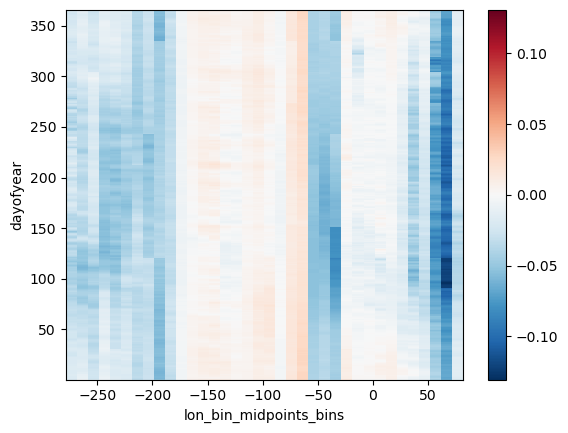

In [20]:
(U_10deg_binned_daily_climatology*CDW_mask ).mean('potrho0').plot(x='lon_bin_midpoints_bins')

In [21]:
#removing weird infinite values
U_10deg_binned_daily_climatology = U_10deg_binned_daily_climatology.where(U_10deg_binned_daily_climatology<1e11)\
.where(U_10deg_binned_daily_climatology>-1e11)

In [24]:
#setting parameters for sabing it
U_10deg_binned_daily_climatology.name='ASCspeed'
U_10deg_binned_daily_climatology_tosave = U_10deg_binned_daily_climatology.rename({'lon_bin_midpoints_bins':'lon_bins'})
U_10deg_binned_daily_climatology_tosave['lon_bins'] = lon_bin_mid
U_10deg_binned_daily_climatology_tosave.to_netcdf('/g/data/ik11/users/wf4500/ASC_project_files/DailyU_climatology_rho_10deg_bins.nc')



# Sanity test

In [25]:
#importing saved ASC
U_10deg_binned_daily_climatology = xr.open_dataset('/g/data/ik11/users/wf4500/ASC_project_files/DailyU_climatology_rho_10deg_bins.nc').ASCspeed



#testing the resulst after the masks
CDW_mask = xr.open_dataset('/g/data/v45/wf4500/ASC_project_files/CDW_age_Climatology_mask.nc').CDW_mask
CDW_mask['dayofyear'] = U_10deg_binned_daily_climatology['dayofyear']
CDW_mask['lon_bins'] = U_10deg_binned_daily_climatology['lon_bins']



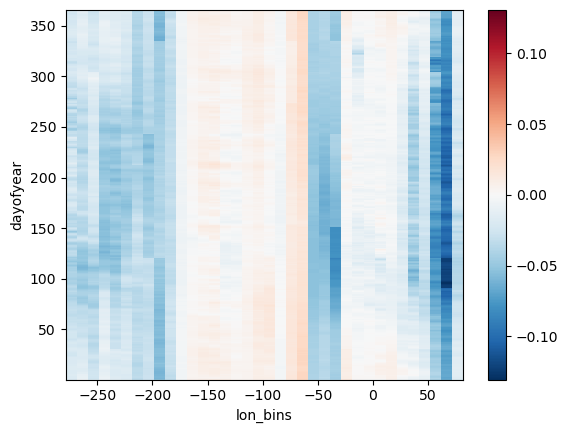

In [26]:
(U_10deg_binned_daily_climatology*CDW_mask ).mean('potrho0').plot(x='lon_bins')